# **Gibbs Free Energy (ΔG) Prediction Models**

**Overall goal:** develop and assess supervised machine learning models to predict the Gibbs free energy of solvation (ΔG)

**Backround:** ΔG is a crucial property for modeling various chemical processes, including electrochemistry and drug delivery systems.  While traditional methods like quantum mechanics and molecular dynamics have been used extensively for predicting ΔG, machine learning has recently emerged as a popular alternative.  By establishing relationships between molecular structure and activity, machine learning models can effectively predict thermodynamic properties.

In [5]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance



### Part 1
* Load the data
* Separate it into features (X) and target variable (y)
* Handle any missing values by replacing them with zero

In [7]:
# Load the dataset
df = pd.read_csv('Gibbs_predictor_545_data_final_2.csv')

In [8]:
# Separate the features and the target variable and keep only numerical features
X = df.drop(columns=['gibbs_free_energy', 'Solvent_Type'])
y = df['gibbs_free_energy']

# Handle missing values by replacing them with zeros
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

### Part 2
* Divide data into training and testing sets using an 80/20 split
* 50/50 split the testing set into validation and final test sets
* Define 3 models
    * Linear
    * SVM: radial basis function (rbf) kernel with a regularization parameter (C) of 10.
    * RF: 250 trees, 2 samples to split an internal node, 1 sample at a leaf node, the square root of the total number of features as the maximum number of features considered for splitting a node, and disable bootstrapping.

Note: work with these example models as they are, do not try to find better parameters

In [9]:
# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the test set into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Define the models
linear_model = LinearRegression()

svm_model = SVR(kernel='rbf', C=10)

rf_model = RandomForestRegressor(
    n_estimators=250, min_samples_split=2, min_samples_leaf=1,
                                 max_features='sqrt', bootstrap=False)

# Models dictionary
models = {
    'Linear Regression': linear_model,
    'SVM': svm_model,
    'Random Forest': rf_model
}

### Part 3
* Model Evaluation
* Output a .csv file that has the following columns:
    * ```algorithm``` (model) 
    * ```test_score``` : caluclate from test data
    * ```mean absolute error``` : calculate from test data
    * ```standard deviaiton of mean absolute errors``` (calculated using 10-fold cross on the validation dataset.)
* Plot these 3 metrics for the models in one bar plot.

In [12]:
# Function to evaluate models and save results
def evaluate_models(X_train, y_train, X_val, y_val, X_test, y_test, models, output_file='output.csv'):
    results = []
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Get the test score (R²)
        test_score = model.score(X_test, y_test)
        
        # Perform 10-fold cross-validation for mean absolute error and standard deviation
        val_predictions = cross_val_predict(model, X_val, y_val, cv=10)
        mae = mean_absolute_error(y_val, val_predictions)
        mae_std = np.std(np.abs(val_predictions - y_val))
        
        # Store results
        results.append({
            'algorithm': model_name,
            'test_score': test_score,
            'mean_absolute_error': mae,
            'std_dev_mae': mae_std
        })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Print the results to the console
    print(results_df)
    
    # Save the results to a CSV file
    results_df.to_csv(output_file, index=False)
    
    return results_df

# Evaluate models and save the results
results_df = evaluate_models(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, models)



           algorithm  test_score  mean_absolute_error   std_dev_mae
0  Linear Regression    0.820882         6.507996e+06  1.044881e+08
1                SVM    0.909262         5.235155e-01  1.050801e+00
2      Random Forest    0.958011         5.345402e-01  9.569261e-01


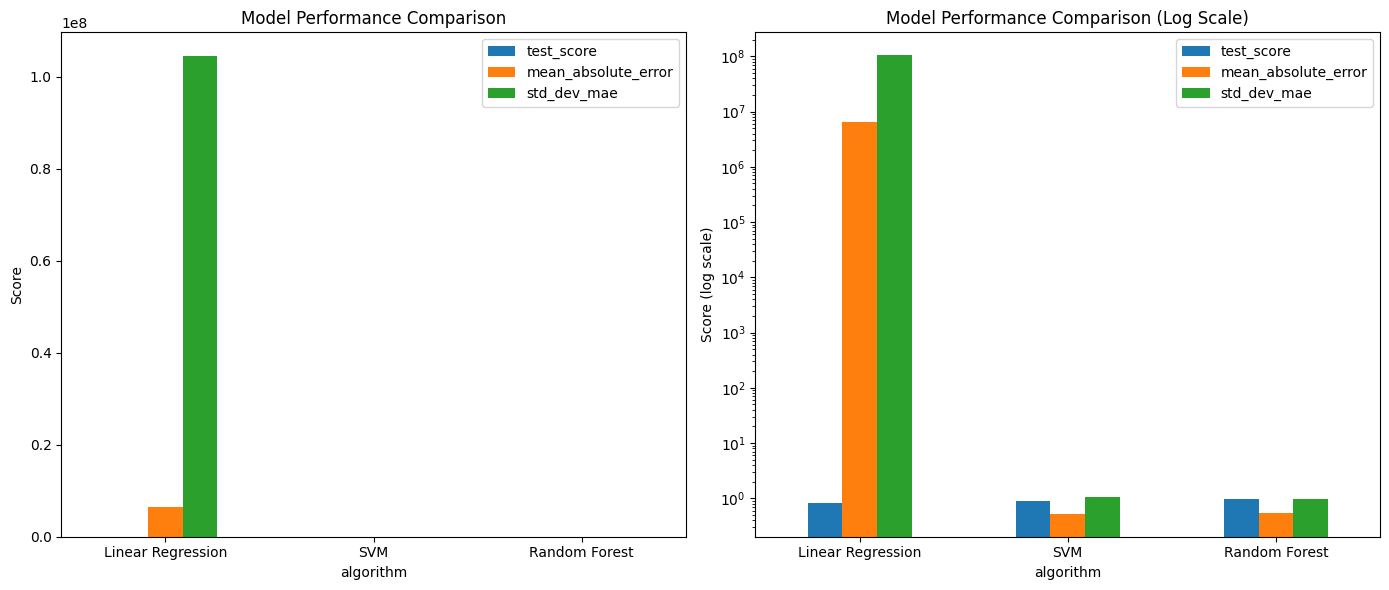

In [13]:

# Function to plot the performance metrics
def plot_metrics(results_df):
    # Metrics to be plotted
    metrics = ['test_score', 'mean_absolute_error', 'std_dev_mae']
    
    # Create a figure with two subplots (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar plot (regular scale)
    results_df.set_index('algorithm')[metrics].plot(kind='bar', ax=ax1)
    ax1.set_ylabel('Score')
    ax1.set_title('Model Performance Comparison')
    ax1.set_xticklabels(results_df['algorithm'], rotation=0)
    
    # Log-scale bar plot
    results_df.set_index('algorithm')[metrics].plot(kind='bar', ax=ax2)
    ax2.set_ylabel('Score (log scale)')
    ax2.set_title('Model Performance Comparison (Log Scale)')
    ax2.set_xticklabels(results_df['algorithm'], rotation=0)
    
    # Set log scale on y-axis for the second plot
    ax2.set_yscale('log')
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot the performance metrics
plot_metrics(results_df)


In [14]:
# Function to calculate permutation feature importance
def calculate_permutation_importance(X_train, y_train, models):
    importance_results = {}
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Compute permutation importance
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
        
        # Store the importance values
        importance_results[model_name] = result.importances_mean  # Mean importance score
    
    return importance_results

# Function to plot feature importance for all models
def plot_feature_importance(importance_results, X_train):
    # Create a DataFrame from the importance results
    importance_df = pd.DataFrame(importance_results, index=X_train.columns)
    
    # Plot horizontal bar chart for feature importance
    importance_df.plot(kind='barh', figsize=(12, 8))
    
    # Set labels and title
    plt.xlabel('Mean Decrease in Accuracy (Permutation Importance)')
    plt.title('Feature Importance for All Models')
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Calculate permutation feature importance for all models
importance_results = calculate_permutation_importance(X_train_scaled, y_train, models)

# Plot the feature importance
plot_feature_importance(importance_results, X_train)


KeyboardInterrupt: 